# 3️⃣ Statistical Inference
**designed by:** [datamover.ai](https://www.datamover.ai)

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

from r3_helpers import (chain_snap, correlation_analysis,
                        encode_categorical_features, one_way_ANOVA,
                        normlize_data, regression_report)

np.random.seed(42)

**1 Start from the Summary coming from the Exploratory Data Analysis (EDA)**

- Target: `Price` is highly skewed as the median value differs significantly from its mean;
- There are 2 nominal, 4 continuous and 1 discrete feature;
- There are 4 (0.04%) missing values, and they arise all in the target; 
- The Nominal features, i.e., `Adress` and `Zip`, will require some feature engineering to increase the predictive power of these features.
- `Lat` and `Lon` are expected to be combined somehow using feature engineering techniques; 
- `Area` as well as `Price` are highly skewed; hence we expect to apply a log transformation to normalise such features;

**2 Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**
- 💁‍♂️ Try to tailor the [datatype](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes) as much as possible.

In [13]:
data = (
    # load csv
    pd.read_csv("./data/data_train.csv")
    .pipe(
        chain_snap,
        fn=lambda df: df.isna().sum().sum(),
        msg="o Number of missing",
    )
    .pipe(
        chain_snap,
        fn=lambda x: x.duplicated().sum(),
        msg="o Number of duplicate rows that will be removed",
    )
    .drop_duplicates()
    # create log of Price
    .assign(**{"log(Price)": lambda df: np.log(df["Price"])})
)

# load data info
data_info = pd.read_csv("./data/data_info.csv", index_col=0)

TARGET = "Price"

# display some info
display(data.head(3))
display(data_info.transpose())
print(f"o Size dataframe = {data.shape}")
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Number of missing: 4
o Number of duplicate rows that will be removed: 0


,Price,Address,Zip,Area,Room,Lon,Lat,log(Price)
0,425000.0,"Lamarckhof 11 I, Amsterdam",1098 TK,68,3,4.944251,52.352317,12.959844
1,520000.0,"Kiefskamp 24, Amsterdam",1082 KA,80,2,4.872336,52.330330,13.161584
2,700000.0,"Latherusstraat 54, Amsterdam",1032 EC,123,6,4.915060,52.393449,13.458836


,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,nominal,nominal,continuous,discrete,continuous,continuous
missing values,4,0,0,0,0,0,0
type of noise,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free,noise-free


o Size dataframe = (739, 8)
o Data type in Dataset: ['continuous' 'nominal' 'discrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [14]:
columns_dtype = {
    "Price": "Int64",
    "log(Price)": "float64",
    "Address": "category",
    "Zip": "category",
    "Area": "Int64",
    "Room": "Int64",
    "Lon": "float64",
    "Lat": "float64",
}

# Coerce better data type
data = data.astype(columns_dtype)

**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).** 

- **a.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **b.** Carry out $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) or a [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) analysis between two **Ordinal** features.
- **c.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **d.** Use an appropriate version of the [t-test](https://www.investopedia.com/terms/t/t-test.asp) or [analysis of variance](https://www.investopedia.com/terms/a/anova.asp) (ANOVA) to study the relationship between **quantitative** and **categorical** variables.   
- **e.** ‼️ whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;
- **f.** If necessary, transform or construct new features and re-apply the same statistical test;


**a. Analysis of nominal features**

In [15]:
display(data_info.loc[lambda x: x["data_type"] == "nominal"].transpose())

# get list of nominal features and remove Education from the list as we analyzed before together with Education-Num
nominal_list = list(data_info.loc[lambda x: x["data_type"] == "nominal"].index)

,Address,Zip
data_type,nominal,nominal
missing values,0,0
type of noise,noise-free,noise-free


ℹ️ For these two features, conducting a statistical analysis does not make sense as the Address is unique per house, and the Zip code depends on the city. However, we can extract some useful features as follows:
- Extrapolate the city from `Address` as it is expected that the house `Price` will depend on the City, most likely Amsterdam having the highest Price on average;
- According to this [link](https://en.youbianku.com/Netherlands) the `Zip` code is based on four digits followed by two letters, e.g. 1234 AB. The first two digits indicate a `City` and a `Region`, the third digit represents the `Location` and the fourth digit represents the `District`. The first letter indicates the `delivery area`, and the second letter indicates the subdivision of the delivery area. Consequently, the postcode and house number uniquely define a postal address. Let's us create several features based on subsection of the Zip code.

In [16]:
# remove any space in the Zip string
data["Zip"] = data["Zip"].str.replace(" ", "")

# create new features from Address and Zip
data = data.assign(
    **{
        "Zip_num": lambda df: df["Zip"].str[:4].astype(int),
        "City": lambda df: df["Address"].str.split().str[-1],
        "City_number": lambda df: df["Zip"].str[0].astype(int),
        "Region": lambda df: df["Zip"].str[1].astype(int),
        "Location": lambda df: df["Zip"].str[2].astype(int),
        "District": lambda df: df["Zip"].str[3].astype(int),
        "Delivery_area": lambda df: df["Zip"].str[4:],
    }
)

# add this new features to the nominal list
nominal_list = nominal_list + [
    "City",
    "City_number",
    "Region",
    "Location",
    "District",
    "Delivery_area",
]

data.head()

,Price,Address,Zip,Area,Room,Lon,Lat,log(Price),Zip_num,City,City_number,Region,Location,District,Delivery_area
0,425000,"Lamarckhof 11 I, Amsterdam",1098TK,68,3,4.944251,52.352317,12.959844,1098,Amsterdam,1,0,9,8,TK
1,520000,"Kiefskamp 24, Amsterdam",1082KA,80,2,4.872336,52.330330,13.161584,1082,Amsterdam,1,0,8,2,KA
2,700000,"Latherusstraat 54, Amsterdam",1032EC,123,6,4.915060,52.393449,13.458836,1032,Amsterdam,1,0,3,2,EC
3,295000,"1e Kekerstraat 119, Amsterdam",1104VA,91,3,4.981371,52.313749,12.594731,1104,Amsterdam,1,1,0,4,VA
4,650000,"Nieuwevaartweg, Amsterdam",1019AL,87,4,4.954376,52.367982,13.384728,1019,Amsterdam,1,0,1,9,AL


In [17]:
# Let do some double check
display(data.groupby("City")["Zip_num"].nunique())
display(data.groupby("City")["City_number"].nunique())
display(data.groupby("City")["Region"].nunique())
display(data.groupby("City")["Location"].nunique())
display(data.groupby("City")["District"].nunique())
display(data.groupby("City")["Delivery_area"].nunique())

City
Amsterdam    69
Name: Zip_num, dtype: int64

City
Amsterdam    1
Name: City_number, dtype: int64

City
Amsterdam    2
Name: Region, dtype: int64

City
Amsterdam    9
Name: Location, dtype: int64

City
Amsterdam    10
Name: District, dtype: int64

City
Amsterdam    326
Name: Delivery_area, dtype: int64

ℹ️ It turns out that this dataset contains only Houses located in Amsterdam. As a consequence, `City_number` can be discarded since its variance is 0.

In [18]:
print(f"o Variance of City_number: {data['City_number'].var()}")
# drop City_number as it has no variance
_ = data.drop(columns=["City_number"], inplace=True)

o Variance of City_number: 0.0


In [19]:
# Print list without going new line
print(f"o Nominal features: {', '.join(nominal_list)}")

o Nominal features: Address, Zip, City, City_number, Region, Location, District, Delivery_area


,test-type,feature,group-var,f-value,eta-squared,df-effect,df-error,p-value,stat-sign,variance,results
0,one way ANOVA,log(Price),Zip_num,7.016,0.417,68,667,0.000,True,Unequal,untrustworthy
1,one way ANOVA,log(Price),Region,87.948,0.107,1,734,0.000,True,Unequal,untrustworthy
2,one way ANOVA,log(Price),Location,31.590,0.258,8,727,0.000,True,Unequal,untrustworthy
3,one way ANOVA,log(Price),District,2.788,0.033,9,726,0.003,True,Unequal,untrustworthy


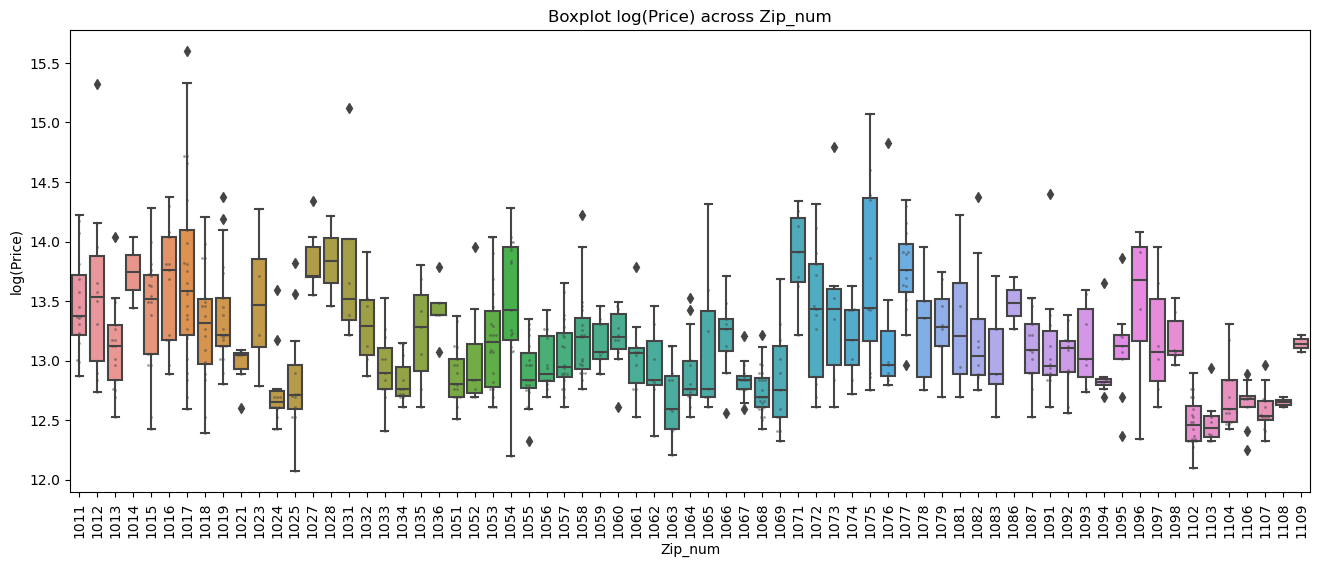

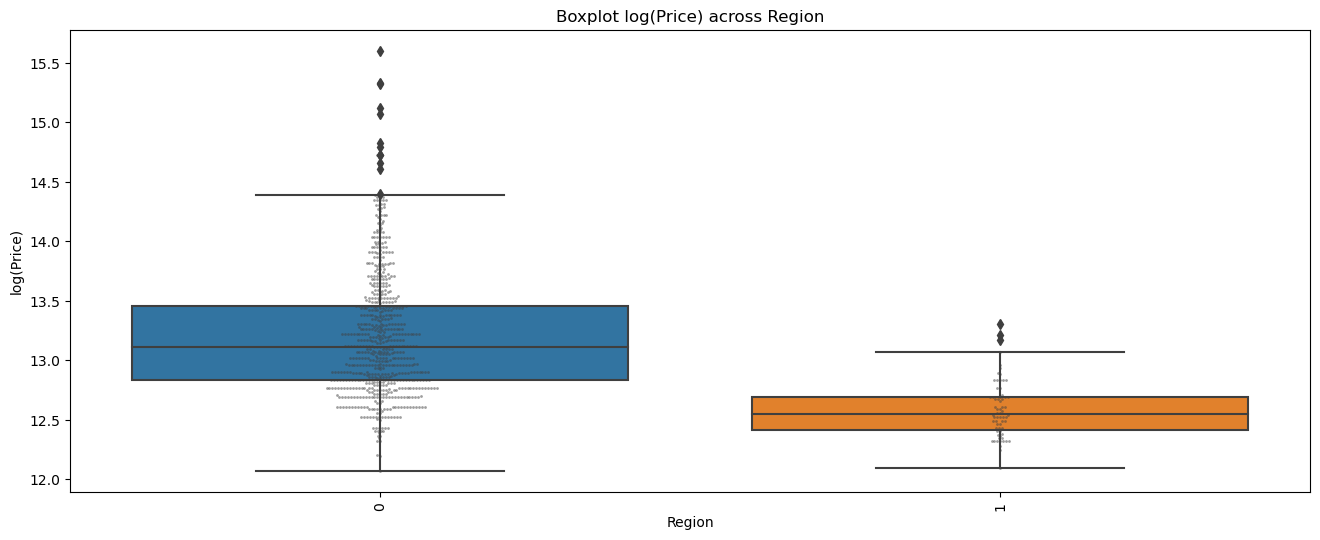

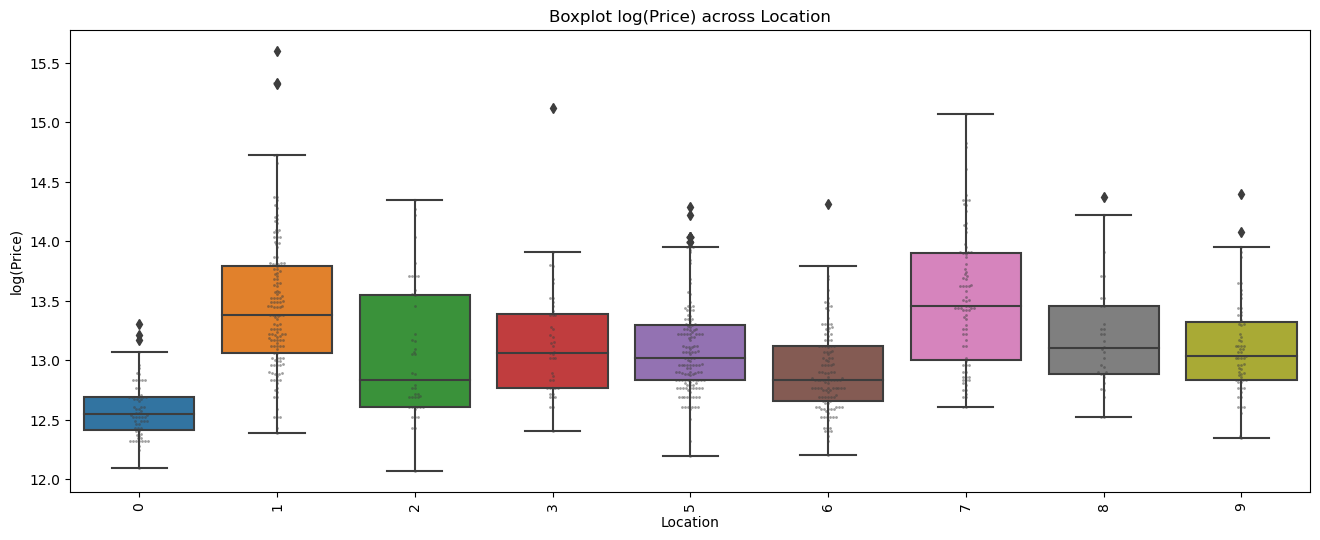

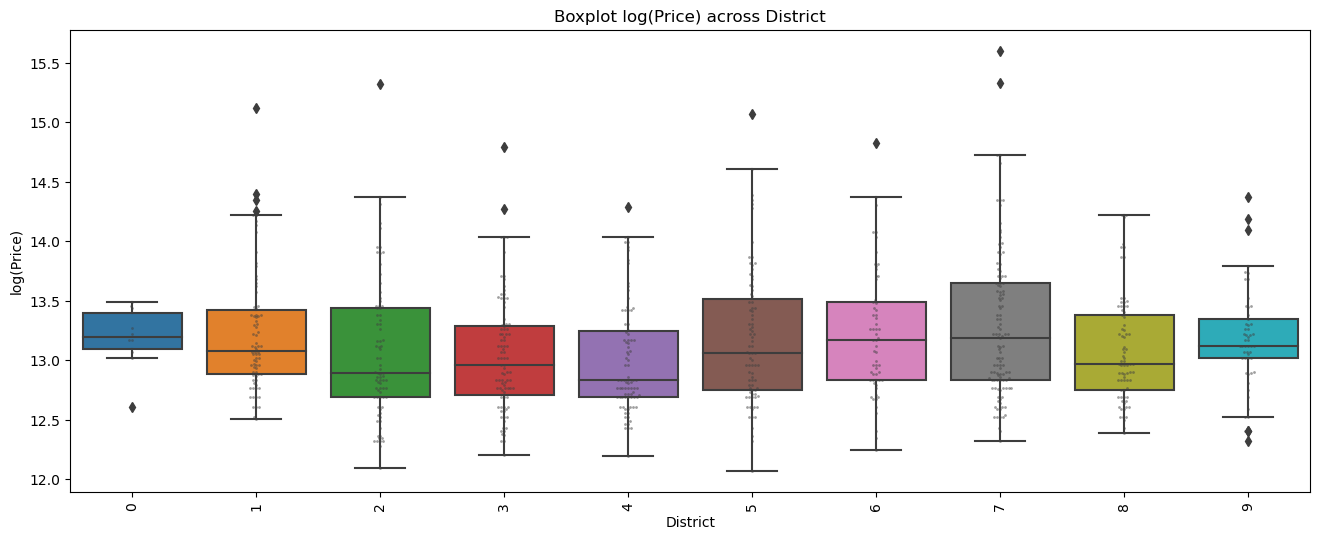

In [20]:
# check if  statistical significance between feature and target
df_summary_anova = pd.DataFrame()

# loop through list
for col in ["Zip_num", "Region", "Location", "District"]:
    # carry out t-test
    df_anova, df_descriptive, _, _ = one_way_ANOVA(
        data=data,
        feature='log(Price)',
        grouping_var=col,
        groups_of_interest=data[col].unique(),
        plot=True,
        figsize=(16, 6)
    )

    # concatenate to summary dataframe
    df_summary_anova = pd.concat([df_summary_anova, df_anova], ignore_index=True)

display(df_summary_anova)

📝 Using a one-way anova we can observe that the `Region` and some of the `Location` have some group difference.

**b. Analysis of ordinal features**

In [21]:
# collect ordinal features
data_info.loc[lambda x: x["data_type"] == "ordinal"]
ordinal_list = list(data_info.loc[lambda x: x["data_type"] == "ordinal"].index)
print(ordinal_list)

[]


ℹ️ No ordinal features are present in this dataset.

**c Analysis of discrete and numerical features**

In [22]:
# collect quantitative features
quantitative_list = data_info.loc[
    lambda x: (x["data_type"] == "discrete") | (x["data_type"] == "continuous")
].index.to_list()
print(f"o Quantitative features: {', '.join(quantitative_list)}")

o Quantitative features: Price, Area, Room, Lon, Lat


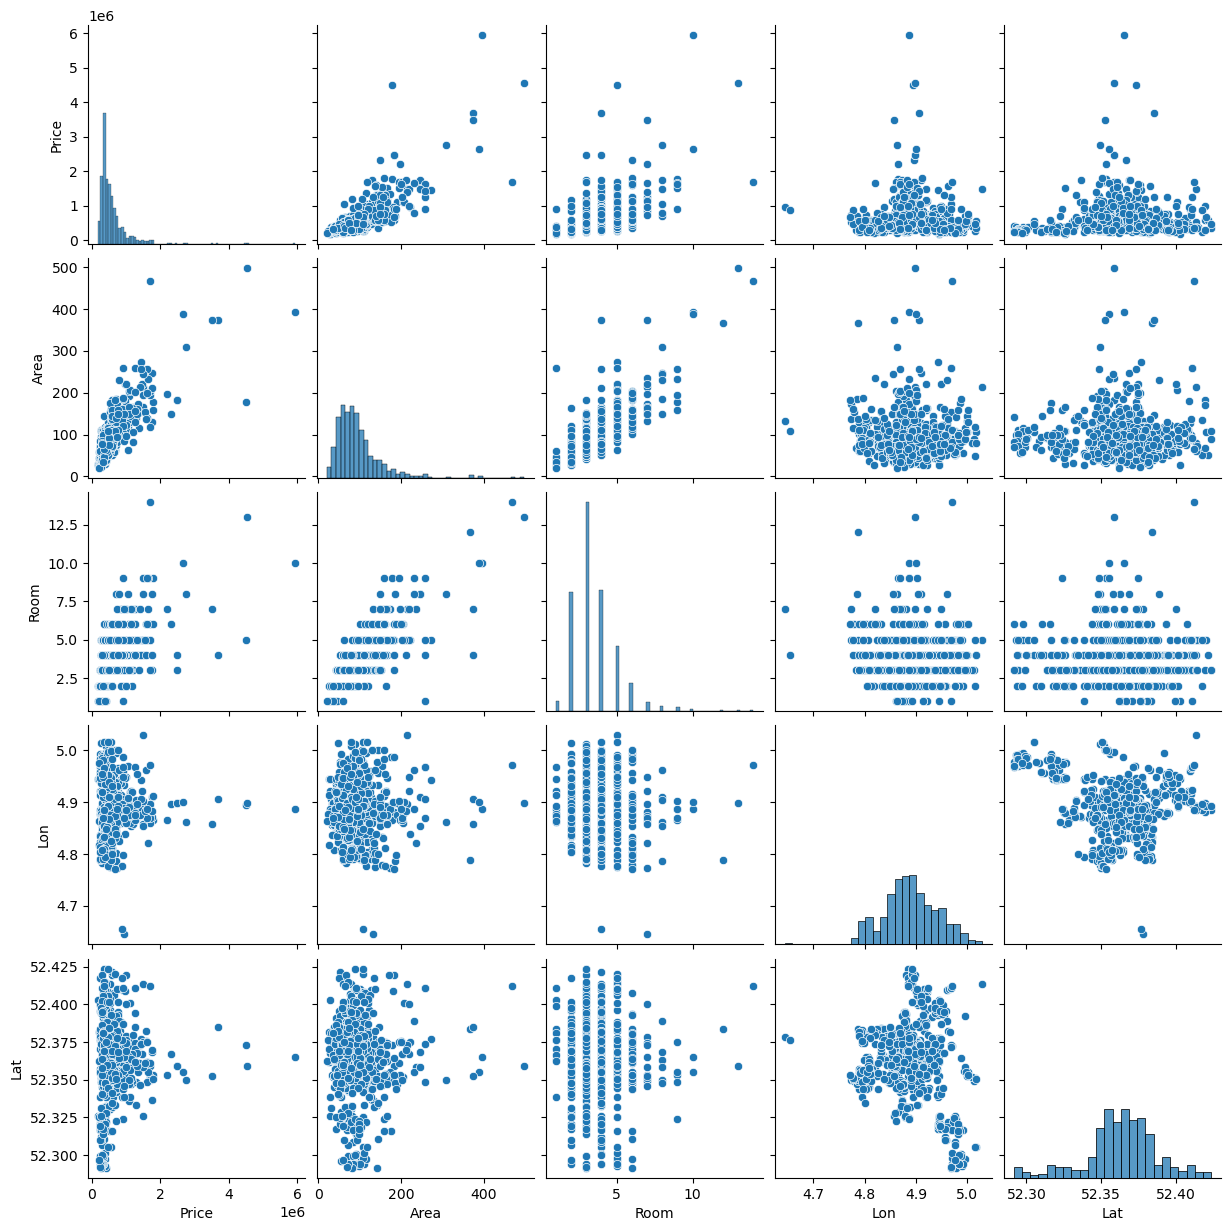

In [23]:
# check correlation, type of distribution and relationship with the target
sns.pairplot(
    data=data.astype(
        dict(zip(quantitative_list, len(quantitative_list) * ["float32"]))
    ),
    vars=quantitative_list,
)

# NOTE: coerce numerical features to float32 otherwise seaborn will complain

📝 From the pair plot we oberseve that:
 - `Price`, `Area` and `Room` are right-skewed. Hence we will apply a log transformation to attempt to normalize these features;
 - `Room` and `Area` appear positively correlated, which make sense as the Area increases as the number of room increases;
 - `Price` appears positively correlated with `Area`, making it a good candidate as a predictor. However, one can observe that the standard deviations of `Price`, monitored over different values of `Area`, are non-constant, leading to the possible issue of [Heteroskedasticity](https://www.investopedia.com/terms/h/heteroskedasticity.asp). 
 - `Lon` and `Lat` appears not correlated with `Price`. We will apply some feature engineering techniques to derive more meaningful features.

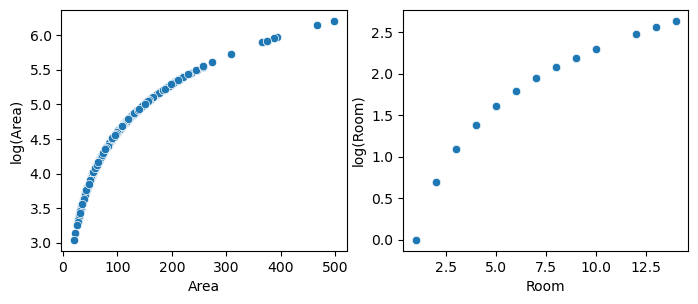

In [24]:
# create log transform of Area and Room
data = data.assign(
    **{
        "log(Area)": lambda df: np.log(df["Area"]),
        "log(Room)": lambda df: np.log(df["Room"]),
    }
)

# plot log transform of Price, Aeas and Room with respect to the original features
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
fig.tight_layout(w_pad=1.0)

for i, feat in zip([0, 1], ["Area", "Room"]):
    sns.scatterplot(data=data, x=feat, y=f"log({feat})", ax=axs[i])

👷 Let us construct two features using Latitude and Longitude by deriving the distance between the centre of Amsterdamm, i.e. [Dam square](https://goo.gl/maps/3Vvx8CBGQms3GW2D8) and the House. We hypothesize that houses closer to the centre are more expensive. There are several ways of describing the distance between two points defined in (Lat, Lon) coordinated. In this case, we will construct:
1. Euclidean Distance
1. Haversine Distance
2. Manhattan Distance

In [25]:
# Define Lat and Lon of Dam Square
Lat_Centrum = 52.373095
Lon_Centrum = 4.893055

In [26]:
def euclidean_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Compute the euclidean distance between two points"""
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

In [27]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [28]:
# generate distance features
data = data.assign(
    **{
        "Euclidean_distance": lambda df: euclidean_distance(
            df["Lat"], df["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Haversine_distance": lambda df: haversine_distance(
            df["Lat"], df["Lon"], Lat_Centrum, Lon_Centrum
        ),
        "Manhattan_distance": lambda df: np.abs(df["Lat"] - Lat_Centrum)
        + np.abs(df["Lon"] - Lon_Centrum),
    }
)

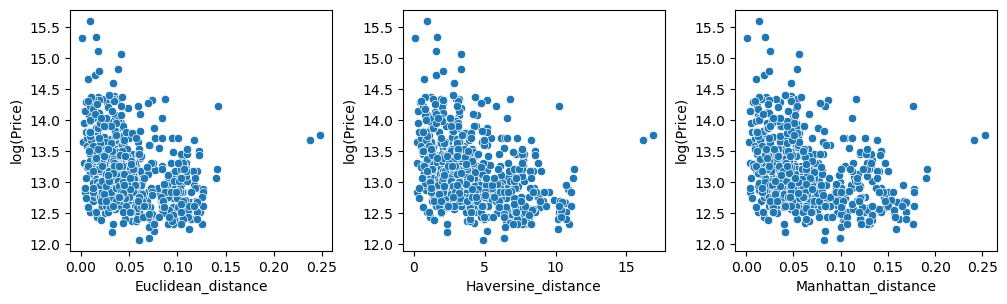

In [29]:
# Plot distance features with respect to the target
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
fig.tight_layout(w_pad=2.0)

for i, feat in zip(
    [0, 1, 2], ["Euclidean_distance", "Haversine_distance", "Manhattan_distance"]
):
    sns.scatterplot(data=data, x=feat, y="log(Price)", ax=axs[i])

In [30]:
# add new features to the quantitative_list
quantitative_list = quantitative_list + [
    "log(Price)",
    "log(Area)",
    "log(Room)",
    "Euclidean_distance",
    "Haversine_distance",
    "Manhattan_distance",
]

In [33]:
# check correlation of all features w.r.t the target and show only the significant ones
dict_results = correlation_analysis(
    data=data[quantitative_list].astype(np.float32),
    dropna="listwise",
    check_norm=True,
    col_list=["log(Price)"],
)
display(dict_results["summary"].round(3))

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,log(Price),Price,1.000,0.000,True,735
1,Spearman Rank,log(Price),Area,0.721,0.000,True,735
2,Spearman Rank,log(Price),Room,0.530,0.000,True,735
3,Spearman Rank,log(Price),Lon,-0.035,0.350,False,735
4,Spearman Rank,log(Price),Lat,0.070,0.059,False,735
5,Spearman Rank,log(Price),log(Area),0.721,0.000,True,735
6,Spearman Rank,log(Price),log(Room),0.530,0.000,True,735
7,Spearman Rank,log(Price),Euclidean_distance,-0.413,0.000,True,735
8,Spearman Rank,log(Price),Haversine_distance,-0.389,0.000,True,735
9,Spearman Rank,log(Price),Manhattan_distance,-0.409,0.000,True,735


In [34]:
dict_results = correlation_analysis(
    data=data[quantitative_list].astype(np.float32),
    dropna="listwise",
    check_norm=True,
    col_list=["log(Area)"],
    row_list=["log(Room)"],
)
display(dict_results["summary"].loc[lambda x: x["stat-sign"] == True].round(3))

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,log(Area),log(Room),0.78,0.0,True,735


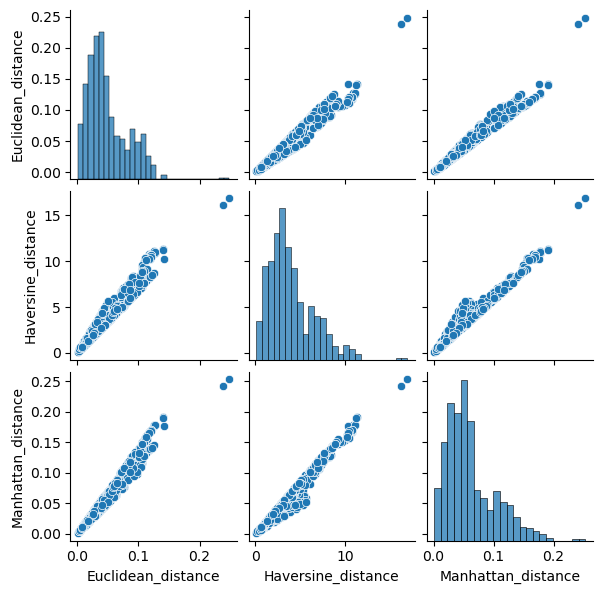

In [35]:
# check correlation, type of distribution and relationship with the target
sns.pairplot(
    data=data,
    vars=["Euclidean_distance", "Haversine_distance", "Manhattan_distance"],
    height=2,
    aspect=1,
)

📝 One can observe that the new features generated using `Lat` and `Lon` are negatively correlated with the target, meaning that the `Price` tends to decrease as the distance increases. On the other hand, the three distances are highly correlated, meaning we must select only one to avoid multi collinearity phenomenon. Furthermore, the logarithm or `Room` and `Area` reasonably correlate with `Price`. 

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 0 to 738
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Price               735 non-null    Int64   
 1   Address             739 non-null    category
 2   Zip                 739 non-null    object  
 3   Area                739 non-null    Int64   
 4   Room                739 non-null    Int64   
 5   Lon                 739 non-null    float64 
 6   Lat                 739 non-null    float64 
 7   log(Price)          735 non-null    float64 
 8   Zip_num             739 non-null    int64   
 9   City                739 non-null    object  
 10  Region              739 non-null    int64   
 11  Location            739 non-null    int64   
 12  District            739 non-null    int64   
 13  Delivery_area       739 non-null    object  
 14  log(Area)           739 non-null    Float64 
 15  log(Room)           739 non-null    Floa

In [24]:
# save data in parquet format to retain data type. Note: It requires pyarrow and fastparquet library
data.to_parquet("./data/data_train_cleaned.parquet")

## Train quick model

In [36]:
# drop na values for now
data = data.dropna(how="any")

# let's set as target the log(Price)
TARGET = "log(Price)"

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=TARGET), data[TARGET], test_size=0.2, random_state=42
)

**Test1:** Run the model with original features

In [42]:
# scale numerical features using StandardScaler
quantitative_features = ['log(Area)', 'Euclidean_distance']
categorical_features = ['Region']

X_train_num, X_test_num = normlize_data(X_train, X_test, quantitative_features)
X_train_cat, X_test_cat = encode_categorical_features(X_train, X_test, categorical_features)

X_train_1 = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_1 = pd.concat([X_test_num, X_test_cat], axis=1)

# Fit logistic regression using sklearn
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_1, y_train)

print("r2 score Linear Regression: ", lr.score(X_test_1, y_test))

# report_lr_original = regression_report(
#     y_true=y_test,
#     y_pred=logreg.predict(X_test_1),
#     label="LR original",
#     show_description=False,
# )

# # Fit random forest using sklearn
rf = DecisionTreeRegressor(random_state=42)
rf.fit(X_train_1, y_train)

print("r2 score Decision Tree: ", rf.score(X_test_1, y_test))

# report_rf_original = classification_report(
#     y_true=y_test,
#     y_pred=rf.predict(X_test_1),
#     label="RF original",
#     show_description=False,
# )



r2 score Linear Regression:  0.7923116165872762
r2 score Decision Tree:  0.771499239726541


/Users/giovanni/opt/anaconda3/envs/dv-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
